# Naive Bayes NLP

In [1]:
import pandas as pd
import sklearn as sklearn

La biblioteca xlrd se usa para acceder a Excel como fuente de datos. Los datos originales contienen macros (xlsx), por lo tanto se requiere una bilbioteca adicional (openpyxl).

In [ ]:
!pip3 install --user xlrd
!pip3 install --user openpyxl

In [2]:
import os

df=pd.read_excel(
     os.path.join("data", "reclamos_20201221_con_clas.xlsx"),
     engine='openpyxl',
)

In [3]:
df.columns

Index(['CASO_ID', 'MERCADO_ANALISTA', 'DESCRIPCION_CIUDADANO',
       'PETICION_CIUDADANO'],
      dtype='object')

In [4]:
df['MERCADO_ANALISTA']=df['MERCADO_ANALISTA'].astype('category')

In [5]:
df.head()

,CASO_ID,MERCADO_ANALISTA,DESCRIPCION_CIUDADANO,PETICION_CIUDADANO
0,638428.0,APIA -Reclamo Seguros,RECIBI UN CORREO ELECTRONICO DONDE SE ME INDIC...,DADO QUE NINGUNA DE LAS CAUSALES ANTERIORES SE...
1,580194.0,APIA -Reclamo Seguros,Mi nombre es XX y el día 27 de Enero de este a...,Necesito que Metlife me deposite el dinero sol...
2,447321.0,APIA -Reclamo Seguros,Estimados Señores SVS\n\nCon fecha 13 de Octub...,Por esta razón quiero colocar un reclamo forma...
3,437201.0,APIA -Reclamo Seguros,En primera instancia solicité renvar mi tarjet...,Solicito devolución de lo que me cobraron por ...
4,385926.0,Reclamo Valores,reclamo en contra Scotiabank por cobros de man...,condonacion de los cobros que hace el Banco.


Al contar los datos pertencientes a cada clase, se observa desbalance de clases.

In [6]:
df.groupby('MERCADO_ANALISTA').count()

,CASO_ID,DESCRIPCION_CIUDADANO,PETICION_CIUDADANO
MERCADO_ANALISTA,,,
APIA -Reclamo Seguros,662,662,662
Reclamo Valores,337,337,337


In [6]:
df.loc[0]['DESCRIPCION_CIUDADANO']

'RECIBI UN CORREO ELECTRONICO DONDE SE ME INDICA QUE  ZURICH SANTANDER SEGUROS HA DECIDIDO NO RENOVAR LA PÓLIZA Nº XX - SÚPER SEGURO ALIVIO SEGURO FAMILIAR POR UN NUEVO PERÍODO, CONFORME AL ARTÍCULO 5 DE LAS CONDICIONES GENERALES DE SU SEGURO (POL 2 99 003). \n\nSEGÚN HE REVISADO, LA POL 299 003 CORRESPONDE A UNA POLIZA DE PRESTACIONES MEDICAS, LA CUAL ESTA PROHIBIDA POR RESOLUCION N°541 DE 15/09/2010.\n\nADEMÁS REVISANDO ANTECEDENTES ENTIENDO QUE LA COMPAÑÍA NO PUEDE PONER TERMINO UNILATERAL A DICHO SEGURO A MENOS QUE SE CUMPLA ALGUNA DE LAS CAUSALES COMO “NO PAGO DE LA PRIMA; CAMBIO DE LO QUE SE ASEGURÓ; OMISIÓN O FALSEO DE INFORMACIÓN POR PARTE DEL CLIENTE; PÉRDIDA TOTAL O PARCIAL, DESTRUCCIÓN DE LOS RIESGOS O LO ASEGURADO TRAS FIRMAR EL CONTRATO, AÚN SI EL EVENTO TIENE O NO COBERTURA. CAMBIO EN LA MONEDA DE LA PÓLIZA”.\n'

In [7]:
df.loc[0]['PETICION_CIUDADANO']

'DADO QUE NINGUNA DE LAS CAUSALES ANTERIORES SE CUMPLE ES QUE VENGO A SOLICITAR A UDS INTERVENGAN EN ESTA DECISION UNILATERAL DE LA COMPAÑÍA Y SE RECHAZE LA NO RENOVACION DE MI POLIZA TOMADA HACE10 AÑOS (13/09/2006) '

In [8]:
df.loc[0]['MERCADO_ANALISTA']

'APIA -Reclamo Seguros '

In [37]:
df.loc[500]['DESCRIPCION_CIUDADANO']

'Necesito,\nSaber cual es la forma de obtener información sobre la constructora Curauma quien se dio a quiebra y no ha dado ninguna información a los acciones pequeños como yo, he tratado de comunicarme vía teléfono sin respuesta de esta entidad.'

In [9]:
df.loc[500]['PETICION_CIUDADANO']

'saber si puedo recuperar algo de mi inversion'

In [10]:
df.loc[500]['MERCADO_ANALISTA']

'Reclamo Valores'

Borramos los datos nulos

In [11]:
df=df[['MERCADO_ANALISTA','PETICION_CIUDADANO','DESCRIPCION_CIUDADANO']].dropna()

In [12]:
df['DESCRIPCION_CIUDADANO']=df['DESCRIPCION_CIUDADANO'].map(str).str.lower()
df['PETICION_CIUDADANO']=df['PETICION_CIUDADANO'].map(str).str.lower() 

Juntamos los dos campos de texto 'PETICION_CIUDADANO' y 'DESCRIPCION_CIUDADANO'

In [13]:
df['data'] = df['DESCRIPCION_CIUDADANO'] + df['PETICION_CIUDADANO']

In [14]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['data'].apply(remove_punct)

In [15]:
df['data'][-20:]

979    desde hace años mantengo inversiones en fondos...
980    metlife compañía de seguros de vida rechaza el...
981    el problema es que depsoite dinero a esta iden...
982    con fecha octubre de contrate un credito de co...
983    en noviembre del mes pasado presente los antec...
984    estimados buenos días estoy interesado en comp...
985    muy buenos días a continuación les envío la pr...
986    buenas tardes se ejecuto la venta de mis accio...
987    no estoy de acuerdo su carta n° del que ustede...
988    xx es una entidad informante por estar afecta ...
989    junto con saludar envió reclamo por la no devo...
990    hace un par de años fui cliente del banco en c...
991    buenas tardes tratare de ser breve y preciso h...
992    estimados el de febrero durante mis vacaciones...
993    hace un año me entere que tenia acciones de mi...
994    estimados por favor revisar el proceso de fusi...
995    con fecha de febrero del me fueron protestados...
996    mal calculo de valor pól

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

n_documents = df.shape[0]
count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents) 
train_binary_bag_of_words = count_vectorizer.fit_transform(df['data']).todense() 


In [17]:
train_binary_bag_of_words.shape

(999, 5973)

In [18]:
labels=(df['MERCADO_ANALISTA']=='Reclamo Valores').astype(int)

In [19]:
labels.shape

(999,)

# Bernoulli Naive Bayes

C.D. Manning, P. Raghavan and H. Schuetze (2008). Introduction to Information Retrieval. Cambridge University Press, pp. 234-265. https://nlp.stanford.edu/IR-book/html/htmledition/the-bernoulli-model-1.html

A. McCallum and K. Nigam (1998). A comparison of event models for naive Bayes text classification. Proc. AAAI/ICML-98 Workshop on Learning for Text Categorization, pp. 41-48.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_binary_bag_of_words, labels, test_size=0.2)

In [21]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
import numpy as np


for a in np.linspace(1.0e-10,1,10):
    clf = BernoulliNB(alpha=a)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    print('alpha : {0:0.2f}, accuracy: {1:0.2f}'.format(a,score))

alpha : 0.00, accuracy: 0.85
alpha : 0.11, accuracy: 0.96
alpha : 0.22, accuracy: 0.96
alpha : 0.33, accuracy: 0.95
alpha : 0.44, accuracy: 0.95
alpha : 0.56, accuracy: 0.95
alpha : 0.67, accuracy: 0.95
alpha : 0.78, accuracy: 0.95
alpha : 0.89, accuracy: 0.95
alpha : 1.00, accuracy: 0.95


In [23]:
from sklearn.metrics import classification_report

clf = BernoulliNB(alpha=0.33)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       130
           1       0.96      0.91      0.93        70

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



# Bayesian Naive Bayes

Ahora, en vez de considerar distribuciones de Bernoulli, utilizamos distribuciones conjugadas (Beta)

In [24]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
tfd = tfp.distributions

def get_prior(y):
    probs=[np.sum(y==c_k)/len(y) for c_k in np.unique(y)]
    print('The class priors are {}'.format(np.sum(probs)))
    priors=tfd.Categorical(probs=probs)
    return priors

In [25]:
prior=get_prior(labels)

The class priors are 1.0


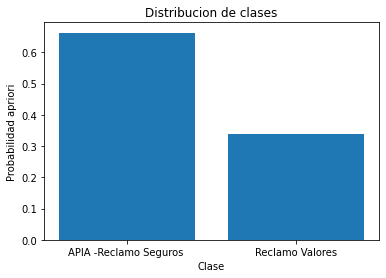

In [26]:
import matplotlib.pyplot as plt

str_labels=df['MERCADO_ANALISTA'].unique()

unique_labels=np.unique(labels)
plt.bar(range(2), prior.probs.numpy())
plt.xlabel("Clase")
plt.ylabel("Probabilidad apriori")
plt.title("Distribucion de clases")
plt.xticks(range(2), str_labels)
plt.show()

Los datos originales de las imagenes contienen regiones donde siempre los valores son cero. Una forma de suavizar la estimacion de probabilidades condicionales es usar suavizado de Laplace (https://en.wikipedia.org/wiki/Additive_smoothing)

In [27]:
def laplace_smoothing(binary_data,labels,alpha=1):
    n_words=binary_data.shape[1]
    n_classes=len(np.unique(labels))
    theta = np.zeros([n_classes, n_words])
    for c_k in range(n_classes):
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of pixels in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)
    return theta

$p(\theta | D) \propto p(\theta)p(D | \theta)$

$p(\theta | a, b) = \frac{\theta^{a - 1}(1 - \theta)^{\beta - 1}}{\beta(a,b)}$

El estimador de maxima verosimilitud para la distrbucion Beta es:

$\hat{\theta}_{\text{map}} = \frac{\alpha + n_1 - 1}{\alpha + \beta + n_1 + n_2 - 2}$

In [28]:
def get_class_conditionals(probs):
    class_conditionals=tfd.Bernoulli(probs=probs)
    return class_conditionals

def predict_sample(prior, class_conditionals, sample):
    cond_probs = class_conditionals.log_prob(sample)
    prior_probs=prior.logits_parameter()
    joint_likelihood = tf.add(prior_probs, tf.reduce_sum(cond_probs,axis=1))
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    return tf.math.exp(log_prob).numpy()

def predict_class(prior, class_conditionals, x):
    pred=[]
    for sample in x:
        prob=predict_sample(prior, class_conditionals,sample)
        pred.append(prob.argmax())
    return pred


In [29]:
for a in np.linspace(0,1,10):
    theta=laplace_smoothing(X_train,y_train,alpha=a)
    class_conditionals=get_class_conditionals(theta)
    y_pred_tfp=predict_class(prior, class_conditionals, X_test)
    score = metrics.accuracy_score(y_test, y_pred_tfp)
    print('alpha : {0:0.2f}, accuracy: {1:0.2f}'.format(a,score))

alpha : 0.00, accuracy: 0.68
alpha : 0.11, accuracy: 0.96
alpha : 0.22, accuracy: 0.96
alpha : 0.33, accuracy: 0.95
alpha : 0.44, accuracy: 0.95
alpha : 0.56, accuracy: 0.95
alpha : 0.67, accuracy: 0.95
alpha : 0.78, accuracy: 0.95
alpha : 0.89, accuracy: 0.95
alpha : 1.00, accuracy: 0.95


In [30]:
from sklearn.metrics import classification_report

theta=laplace_smoothing(X_train,y_train,alpha=0.33)
class_conditionals=get_class_conditionals(theta)
y_pred_tfp=predict_class(prior, class_conditionals, X_test)
print(classification_report(y_test, y_pred_tfp))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       130
           1       0.96      0.91      0.93        70

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



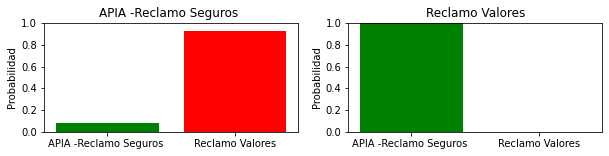

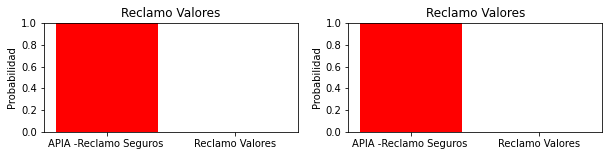

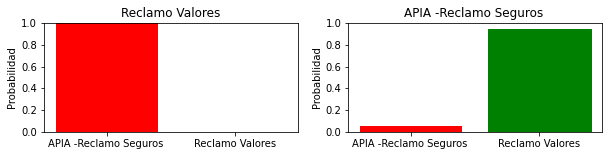

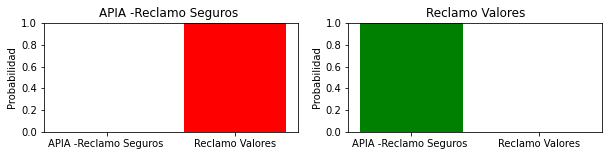

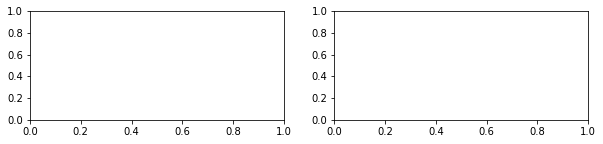

In [31]:
class_error=y_pred_tfp!=y_test
X_error=X_test[class_error]
true_label=y_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(1,n_error+1,2):
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    for j in range(2):
        if(i+j<n_error):
            err_pred=predict_sample(prior, class_conditionals,X_error[i+j,:])
            bar=ax[j].bar(str_labels, err_pred, color='red')
            bar[int(true_label.iloc[i])].set_color('green')
            ax[j].set_title(str_labels[int(true_label.iloc[i+j])])
            ax[j].set_ylim([0, 1])
            ax[j].set_ylabel('Probabilidad')
plt.show()